# Notebook 04 — Forecasting & Theatre Capacity Planning

## Surgical Trends and Case Mix Analysis with Anesthesia Utilization (2022–2025)

**Objective:** Use historical monthly theatre activity (2022–2025) to (1) forecast near-term demand and (2) translate forecasts into practical capacity planning guidance (theatre sessions, anaesthesia cover).

This notebook forecasts:
- Monthly **total surgical volume**
- Monthly **emergency volume** and **emergency share**
- Monthly **anaesthesia workload mix** (General vs Regional)

> **Note:** Forecasts are decision-support tools, not guarantees. Use them alongside clinical realities, policy changes, and resource constraints.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load cleaned master dataset

data_path = "SURGICAL_MASTER_2022_2025.xlsx"
df = pd.read_excel(data_path)

print("Rows:", len(df))
print("Columns:", df.columns.tolist())
df.head()


Rows: 62459
Columns: ['MONTH', 'AGE', 'SEX', 'TYPE_OF_SURGERY', 'SPECIALTY', 'DIAGNOSIS', 'OPERATIONS', 'ANESTHESIA', 'YEAR', 'MONTH_NAME', 'YEAR_MONTH', 'AGE_NUM', 'AGE_YEARS', 'AGE_GROUP', 'ANESTHESIA_IMPUTED']


,MONTH,AGE,SEX,TYPE_OF_SURGERY,SPECIALTY,DIAGNOSIS,OPERATIONS,ANESTHESIA,YEAR,MONTH_NAME,YEAR_MONTH,AGE_NUM,AGE_YEARS,AGE_GROUP,ANESTHESIA_IMPUTED
0,2022-01-01,27,MALE,EL,OPHTHA,CORNEAL LACERATION,CORNEAL REPAIR,LA,2022,January,2022-01,27.0,27.0,19–35,False
1,2022-01-01,9,MALE,EL,OPHTHA,CORNEAL PERFORATION,CORNEAL REPAIR,GA,2022,January,2022-01,9.0,9.0,6–12,False
2,2022-01-01,32,FEMALE,EM,GYNAE,RIGHT ECTOPIC PREGNANCY,EXPLORATORY LAPAROTOMY/SALPINGECTOMY,GA,2022,January,2022-01,32.0,32.0,19–35,False
3,2022-01-01,43,MALE,EM,GEN. SURGERY,MULTIPLE FACIAL LACERATION,DEBRIDEMENT/STITCHING,GA,2022,January,2022-01,43.0,43.0,36–60,False
4,2022-01-01,22,MALE,EM,GEN. SURGERY,COMPLICATED APPENDICITS,APPENDICITS,GA,2022,January,2022-01,22.0,22.0,19–35,False


In [3]:
# --- Preprocessing ---

# 1) Parse YEAR_MONTH to a monthly timestamp (Month Start)
df["YEAR_MONTH_DT"] = pd.to_datetime(df["YEAR_MONTH"], errors="coerce").dt.to_period("M").dt.to_timestamp()

# 2) Clean surgery type (hospital uses EM/EL)
df["SURGERY_TYPE_CLEAN"] = (
    df["TYPE_OF_SURGERY"].astype(str).str.strip().str.upper()
    .replace({"EM": "Emergency", "EL": "Elective"})
)

# 3) Build anaesthesia groups from the raw ANESTHESIA text field
def group_anaesthesia(x):
    s = str(x).strip().upper()

    # General anaesthesia
    if s in ["GA", "G/A", "G.A", "GENERAL", "GENERAL ANAESTHESIA", "GENERAL ANESTHESIA"]:
        return "General"

    # Regional / spinal
    if s in ["SA", "S.A", "S. A", "S/A", "SAB",
             "SPINAL", "SPINAL ANAESTHESIA", "SPINAL ANESTHESIA",
             "SADDLE BLOCK", "SPINAL BLOCK",
             "BLOCK", "WRIST BLOCK", "REGIONAL BLOCK"]:
        return "Regional"

    # Local
    if s in ["LA", "L/A", "LOCAL", "TOPICAL", "WALANT"]:
        return "Local"

    # Sedation / MAC
    if "SEDATION" in s or "MAC" in s:
        return "Sedation/MAC"

    # Combined (conversion) cases
    if "SA/GA" in s or "GA/SA" in s:
        return "Combined"

    return "Other"

df["ANESTHESIA_GROUP"] = df["ANESTHESIA"].apply(group_anaesthesia)

# Quick validation
display(df["SURGERY_TYPE_CLEAN"].value_counts())
display(df["ANESTHESIA_GROUP"].value_counts())


Elective     32002
Emergency    30457
Name: SURGERY_TYPE_CLEAN, dtype: int64

General         40085
Regional        17637
Local            2745
Other            1201
Sedation/MAC      754
Combined           37
Name: ANESTHESIA_GROUP, dtype: int64

In [4]:
# --- Monthly aggregation ---
monthly = (
    df.dropna(subset=["YEAR_MONTH_DT"])
      .groupby("YEAR_MONTH_DT")
      .agg(
          total_cases=("YEAR_MONTH_DT", "size"),
          emergency_cases=("SURGERY_TYPE_CLEAN", lambda s: s.str.contains("Emergency").sum()),
          elective_cases=("SURGERY_TYPE_CLEAN", lambda s: s.str.contains("Elective").sum()),
          ga_cases=("ANESTHESIA_GROUP", lambda s: (s == "General").sum()),
          ra_cases=("ANESTHESIA_GROUP", lambda s: (s == "Regional").sum()),
      )
      .sort_index()
)

monthly["emergency_pct"] = monthly["emergency_cases"] / monthly["total_cases"]
monthly["ga_pct"] = monthly["ga_cases"] / monthly["total_cases"]
monthly["ra_pct"] = monthly["ra_cases"] / monthly["total_cases"]

# Ensure statsmodels sees a monthly frequency
monthly = monthly.asfreq("MS")

monthly.head()


,total_cases,emergency_cases,elective_cases,ga_cases,ra_cases,emergency_pct,ga_pct,ra_pct
YEAR_MONTH_DT,,,,,,,,
2022-01-01,1274,733,541,690,511,0.575353,0.541601,0.401099
2022-02-01,1337,761,576,802,447,0.569185,0.599850,0.334331
2022-03-01,1586,801,785,983,517,0.505044,0.619798,0.325977
2022-04-01,1367,761,606,797,488,0.556693,0.583029,0.356986
2022-05-01,1406,736,670,828,498,0.523471,0.588905,0.354196


## 1) Quick look at the monthly series

Before forecasting, we confirm whether the monthly series has:
- trend (up/down over time)
- seasonality (repeating monthly pattern)
- volatility (sudden peaks and dips)

We will forecast with two practical model families:
- **Holt-Winters Exponential Smoothing (ETS)** for trend + seasonality  
- **SARIMAX** as an alternative (robust for seasonal structure)

We will use a simple holdout evaluation on the most recent months to compare error.


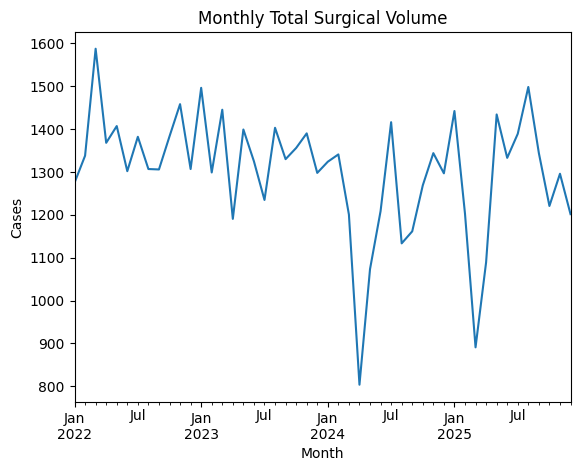

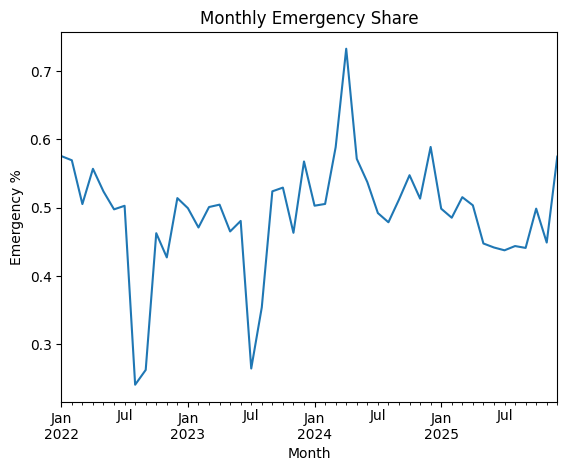

In [5]:
# Plot monthly total cases and emergency share
plt.figure()
monthly["total_cases"].plot()
plt.title("Monthly Total Surgical Volume")
plt.xlabel("Month")
plt.ylabel("Cases")
plt.show()

plt.figure()
monthly["emergency_pct"].plot()
plt.title("Monthly Emergency Share")
plt.xlabel("Month")
plt.ylabel("Emergency %")
plt.show()


## 2) Model evaluation setup

We will:
- hold out the last **6 months** as a test window (if available)
- fit each model on the training window
- compare using **MAE** and **MAPE**

Then we will pick a “best practical model” for each target series.


In [6]:
def train_test_split_ts(series: pd.Series, test_months: int = 6):
    series = series.dropna()
    if len(series) <= test_months + 12:
        # not enough data for a meaningful split; fallback to last 3 months
        test_months = max(3, min(6, len(series)//4))
    train = series.iloc[:-test_months]
    test = series.iloc[-test_months:]
    return train, test

def mae(y_true, y_pred):
    return float(np.mean(np.abs(np.array(y_true) - np.array(y_pred))))

def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return float(np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100)

def fit_predict_ets(train, steps, seasonal_periods=12):
    model = ExponentialSmoothing(
        train,
        trend="add",
        seasonal="add",
        seasonal_periods=seasonal_periods,
        initialization_method="estimated",
    ).fit(optimized=True)
    pred = model.forecast(steps)
    return model, pred

def fit_predict_sarimax(train, steps, order=(1,1,1), seasonal_order=(1,1,1,12)):
    model = SARIMAX(
        train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
    ).fit(disp=False)
    pred = model.forecast(steps)
    return model, pred

def compare_models(series, name, test_months=6):
    train, test = train_test_split_ts(series, test_months=test_months)
    steps = len(test)
    results = []
    
    # ETS
    try:
        _, pred_ets = fit_predict_ets(train, steps)
        results.append(("ETS (Holt-Winters)", mae(test, pred_ets), mape(test, pred_ets)))
    except Exception as e:
        results.append(("ETS (Holt-Winters)", np.nan, np.nan))
    
    # SARIMAX
    try:
        _, pred_smx = fit_predict_sarimax(train, steps)
        results.append(("SARIMAX(1,1,1)(1,1,1,12)", mae(test, pred_smx), mape(test, pred_smx)))
    except Exception as e:
        results.append(("SARIMAX(1,1,1)(1,1,1,12)", np.nan, np.nan))
    
    res_df = pd.DataFrame(results, columns=["Model", "MAE", "MAPE_%"]).sort_values("MAE")
    print(f"=== {name} (Holdout = last {steps} months) ===")
    display(res_df)
    return train, test, res_df

# Compare on key series
train_total, test_total, res_total = compare_models(monthly["total_cases"], "Total Cases")
train_em, test_em, res_em = compare_models(monthly["emergency_cases"], "Emergency Cases")


=== Total Cases (Holdout = last 6 months) ===


,Model,MAE,MAPE_%
1,"SARIMAX(1,1,1)(1,1,1,12)",97.871293,7.019089
0,ETS (Holt-Winters),111.392057,7.878032


=== Emergency Cases (Holdout = last 6 months) ===


,Model,MAE,MAPE_%
1,"SARIMAX(1,1,1)(1,1,1,12)",83.385443,13.250514
0,ETS (Holt-Winters),93.537807,14.740023


## 3) Final forecasting (next 12 months)

We will forecast the next **12 months** for:
- Total cases
- Emergency cases

We’ll also compute:
- Forecast emergency percentage
- Forecast anaesthesia mix (GA%, Regional%) using the same approach on proportions

> If your dataset ends mid-year, interpret “next 12 months” as the next 12 monthly steps beyond the latest available month.


=== Total Cases (Holdout = last 6 months) ===


,Model,MAE,MAPE_%
1,"SARIMAX(1,1,1)(1,1,1,12)",97.871293,7.019089
0,ETS (Holt-Winters),111.392057,7.878032


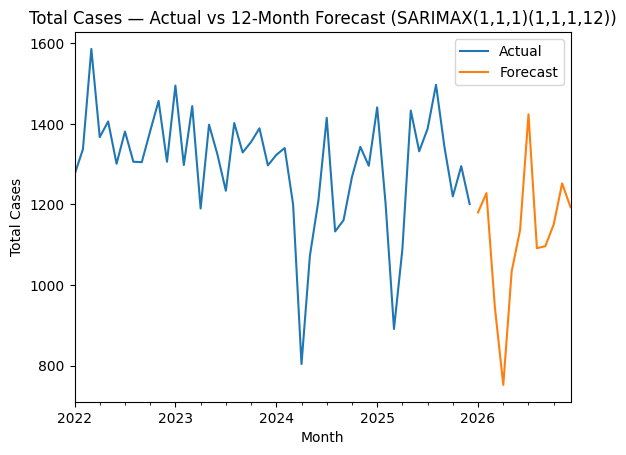

=== Emergency Cases (Holdout = last 6 months) ===


,Model,MAE,MAPE_%
1,"SARIMAX(1,1,1)(1,1,1,12)",83.385443,13.250514
0,ETS (Holt-Winters),93.537807,14.740023


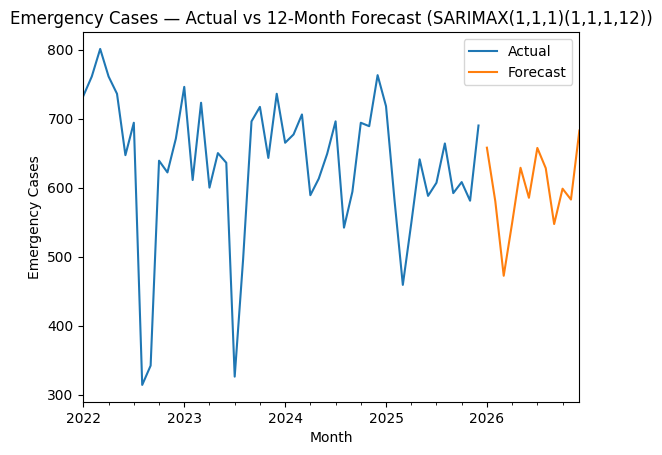

=== GA Share (Holdout = last 6 months) ===


,Model,MAE,MAPE_%
1,"SARIMAX(1,1,1)(1,1,1,12)",0.032167,4.424903
0,ETS (Holt-Winters),0.032240,4.504533


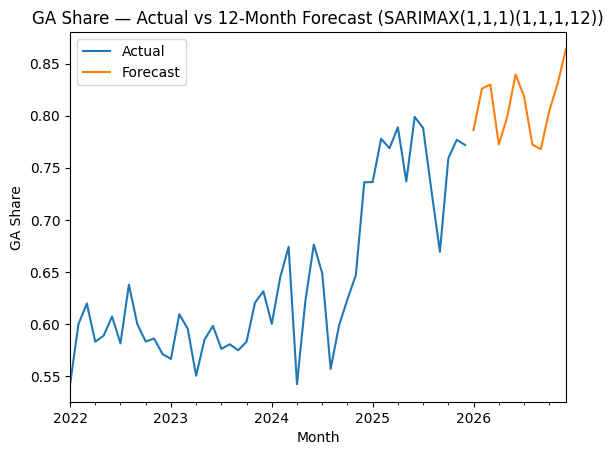

=== Regional Share (Holdout = last 6 months) ===


,Model,MAE,MAPE_%
0,ETS (Holt-Winters),0.048594,23.302843
1,"SARIMAX(1,1,1)(1,1,1,12)",0.058571,28.187070


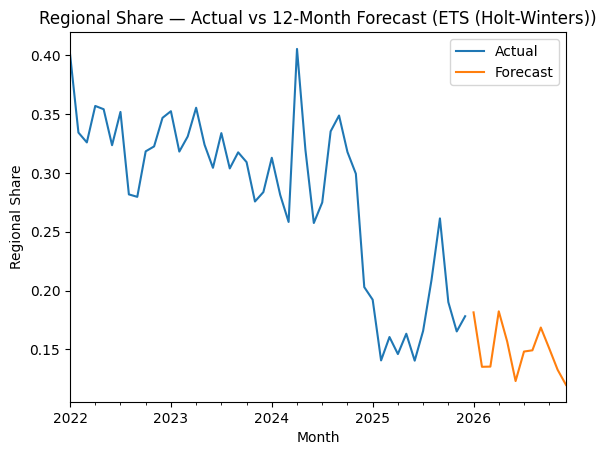

,forecast_total_cases,forecast_emergency_cases,forecast_emergency_pct,forecast_ga_pct,forecast_ra_pct
YEAR_MONTH,,,,,
2026-01-01,1180,658,0.557350,0.786262,0.181464
2026-02-01,1228,580,0.472327,0.826055,0.135173
2026-03-01,945,472,0.499834,0.829864,0.135334
2026-04-01,752,549,0.729380,0.772416,0.182345
2026-05-01,1034,629,0.608080,0.798542,0.156673
2026-06-01,1137,585,0.514858,0.839598,0.123058
2026-07-01,1424,657,0.461827,0.818735,0.148151
2026-08-01,1091,628,0.575488,0.772136,0.149191
2026-09-01,1096,547,0.499052,0.767942,0.168576


In [7]:
FORECAST_HORIZON = 12

def pick_best_model(res_df):
    # pick the model with lowest MAE (ignoring NaN)
    res_df2 = res_df.dropna(subset=["MAE"]).copy()
    if res_df2.empty:
        return "ETS (Holt-Winters)"
    return res_df2.sort_values("MAE").iloc[0]["Model"]

def forecast_series(series, horizon=12, test_months=6, name="Series"):
    train, test, res = compare_models(series, name, test_months=test_months)
    best = pick_best_model(res)
    series_all = series.dropna()
    
    if best.startswith("SARIMAX"):
        model, fc = fit_predict_sarimax(series_all, horizon)
        model_name = "SARIMAX(1,1,1)(1,1,1,12)"
    else:
        model, fc = fit_predict_ets(series_all, horizon)
        model_name = "ETS (Holt-Winters)"
    
    # Plot history + forecast
    plt.figure()
    series_all.plot(label="Actual")
    fc.plot(label="Forecast")
    plt.title(f"{name} — Actual vs {horizon}-Month Forecast ({model_name})")
    plt.xlabel("Month")
    plt.ylabel(name)
    plt.legend()
    plt.show()
    
    return model_name, fc

model_total, fc_total = forecast_series(monthly["total_cases"], horizon=FORECAST_HORIZON, name="Total Cases")
model_em, fc_em = forecast_series(monthly["emergency_cases"], horizon=FORECAST_HORIZON, name="Emergency Cases")

# Proportions (clip into [0,1] after forecasting for sanity)
model_ga, fc_ga = forecast_series(monthly["ga_pct"], horizon=FORECAST_HORIZON, name="GA Share")
model_ra, fc_ra = forecast_series(monthly["ra_pct"], horizon=FORECAST_HORIZON, name="Regional Share")

fc_ga = fc_ga.clip(0, 1)
fc_ra = fc_ra.clip(0, 1)

# Build a forecast table
forecast_df = pd.DataFrame({
    "forecast_total_cases": fc_total.round(0).astype(int),
    "forecast_emergency_cases": fc_em.round(0).astype(int),
    "forecast_emergency_pct": (fc_em / fc_total).clip(0, 1),
    "forecast_ga_pct": fc_ga,
    "forecast_ra_pct": fc_ra,
})
forecast_df.index.name = "YEAR_MONTH"
forecast_df.head(12)


## 4) Translating forecasts into theatre capacity planning

Forecasts are most useful when converted into operational targets.

Below is a simple planning layer that translates forecast volume into **theatre sessions needed**.

You can adjust assumptions:
- average cases per elective session
- average cases per emergency session
- number of theatre days per week
- number of active theatres

This does **not** replace detailed OR-time modelling (which would require case durations and turnover times),
but it provides a practical starting point for leadership planning.


In [8]:
# --- Capacity planning assumptions (adjust as needed) ---
AVG_CASES_PER_ELECTIVE_SESSION = 6     # e.g., 6 elective cases per list/session
AVG_CASES_PER_EMERGENCY_SESSION = 5    # e.g., emergencies often run slower
THEATRE_DAYS_PER_WEEK = 5
ACTIVE_THEATRES = 4

# Derive elective forecast
forecast_df["forecast_elective_cases"] = (forecast_df["forecast_total_cases"] - forecast_df["forecast_emergency_cases"]).clip(lower=0).round(0).astype(int)

# Sessions needed
forecast_df["elective_sessions_needed"] = (forecast_df["forecast_elective_cases"] / AVG_CASES_PER_ELECTIVE_SESSION).round(1)
forecast_df["emergency_sessions_needed"] = (forecast_df["forecast_emergency_cases"] / AVG_CASES_PER_EMERGENCY_SESSION).round(1)
forecast_df["total_sessions_needed"] = (forecast_df["elective_sessions_needed"] + forecast_df["emergency_sessions_needed"]).round(1)

# Convert sessions to weekly load
# approx weeks per month
forecast_df["sessions_per_week_needed"] = (forecast_df["total_sessions_needed"] / 4.33).round(1)

# Available weekly sessions (simple)
available_sessions_per_week = ACTIVE_THEATRES * THEATRE_DAYS_PER_WEEK
available_sessions_per_week


20

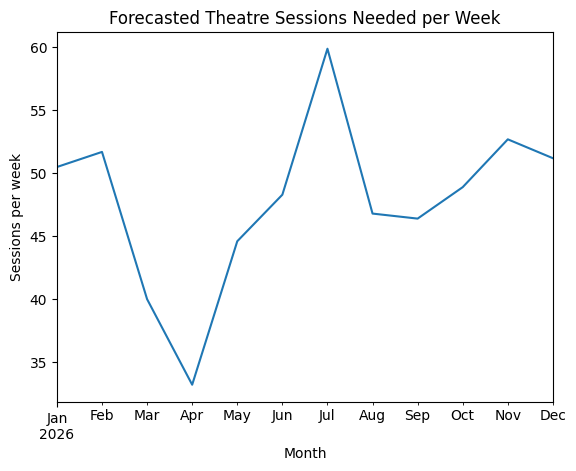

Available sessions per week (assumption): 20


,forecast_total_cases,forecast_emergency_cases,sessions_per_week_needed,capacity_flag
YEAR_MONTH,,,,
2026-01-01,1180,658,50.5,OVER CAPACITY RISK
2026-02-01,1228,580,51.7,OVER CAPACITY RISK
2026-03-01,945,472,40.0,OVER CAPACITY RISK
2026-04-01,752,549,33.2,OVER CAPACITY RISK
2026-05-01,1034,629,44.6,OVER CAPACITY RISK
2026-06-01,1137,585,48.3,OVER CAPACITY RISK
2026-07-01,1424,657,59.9,OVER CAPACITY RISK
2026-08-01,1091,628,46.8,OVER CAPACITY RISK
2026-09-01,1096,547,46.4,OVER CAPACITY RISK


In [9]:
plt.figure()
forecast_df["sessions_per_week_needed"].plot()
plt.title("Forecasted Theatre Sessions Needed per Week")
plt.xlabel("Month")
plt.ylabel("Sessions per week")
plt.show()

print("Available sessions per week (assumption):", available_sessions_per_week)

# Flag months likely to exceed assumed capacity
forecast_df["capacity_flag"] = np.where(forecast_df["sessions_per_week_needed"] > available_sessions_per_week, "OVER CAPACITY RISK", "OK")
forecast_df[["forecast_total_cases","forecast_emergency_cases","sessions_per_week_needed","capacity_flag"]].head(12)


## 5) Anaesthesia staffing signal (GA vs Regional)

We use the forecast GA% and Regional% as a rough staffing signal:
- Higher **GA%** → more GA-dependent lists (e.g., Neuro/ENT)
- Higher **Regional%** → higher block/spinal workload (e.g., Obstetrics/Orthopaedics)

Below is a simple view of the projected anaesthesia mix.


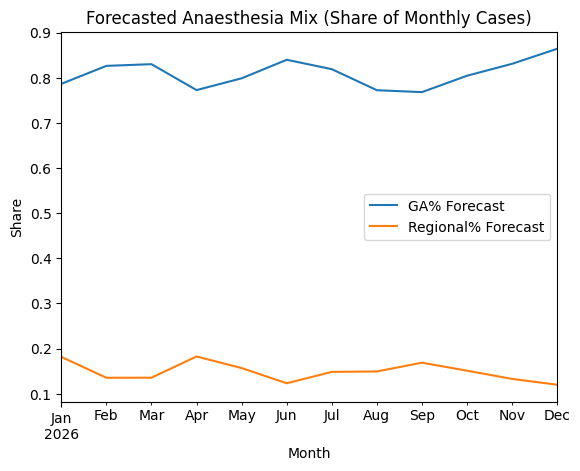

,forecast_ga_pct,forecast_ra_pct,forecast_emergency_pct
YEAR_MONTH,,,
2026-01-01,0.786262,0.181464,0.557350
2026-02-01,0.826055,0.135173,0.472327
2026-03-01,0.829864,0.135334,0.499834
2026-04-01,0.772416,0.182345,0.729380
2026-05-01,0.798542,0.156673,0.608080
2026-06-01,0.839598,0.123058,0.514858
2026-07-01,0.818735,0.148151,0.461827
2026-08-01,0.772136,0.149191,0.575488
2026-09-01,0.767942,0.168576,0.499052


In [10]:
plt.figure()
forecast_df["forecast_ga_pct"].plot(label="GA% Forecast")
forecast_df["forecast_ra_pct"].plot(label="Regional% Forecast")
plt.title("Forecasted Anaesthesia Mix (Share of Monthly Cases)")
plt.xlabel("Month")
plt.ylabel("Share")
plt.legend()
plt.show()

forecast_df[["forecast_ga_pct","forecast_ra_pct","forecast_emergency_pct"]].head(12)


# 6) Conclusions & next actions

### What leadership can do with this forecast (practical)
1. **Set monthly theatre volume targets** using the forecast baseline.  
2. **Plan emergency buffer capacity** when emergency share is projected to rise.  
3. **Adjust anaesthesia deployment** depending on projected GA vs Regional workload.  
4. **Monitor deviations**: if actuals diverge materially from forecast for 2–3 months, re-fit models and investigate operational causes.

### Recommended operational dashboard (monthly)
- Total cases (actual vs forecast)
- Emergency cases and emergency % (actual vs forecast)
- GA% and Regional% (actual vs forecast)
- Sessions needed vs sessions available
- Specialty case-mix (top 8) (from Notebook 02)

### Next modelling upgrade (if you add data later)
To build a high-accuracy capacity model, add:
- case duration (knife-to-skin and total time)
- turnover time
- cancellations and reasons
- ICU utilization (for risk/complexity planning)
